### Defining the question

#### Specifying the question

What are the characteristics exhibited by a patient with hypothyroidism? 

####  Defining the metrics of success

To term my analysis successful, I should have been able to create models for determining whether a patient is positive for hypothyroidism or isn't.

#### Understanding the context

The dataset involved in this analysis is one of patients in a hospital. The data details the patients' characteristics, their given diagnosis of hypothyroidism, whether or not they have certain conditions and tests they underwent. The dataset can be found [here](http://bit.ly/hypothyroid_data).

### Reading the data

Importing relevant libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import tree, ensemble, model_selection, svm, preprocessing, decomposition


Setting standard parameters for my visualizations:

In [ ]:
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.titleweight'] = 700
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 500
sns.set_theme(style='darkgrid')
plt.rcParams['figure.figsize'] = (10,8)

Loading my data

In [ ]:
ht = pd.read_csv("/content/hypothyroid.csv")

### Checking the data

In [ ]:
# checking the shape of the dataset

print('The dataset has',ht.shape[0],'rows and',ht.shape[1],'columns.')

The dataset has 3163 rows and 26 columns.


In [ ]:
# previewing the first 5 columns of our dataset

ht.head()

,status,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,sick,tumor,lithium,goitre,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG
0,hypothyroid,72,M,f,f,f,f,f,f,f,f,f,f,f,y,30,y,0.6,y,15,y,1.48,y,10,n,?
1,hypothyroid,15,F,t,f,f,f,f,f,f,f,f,f,f,y,145,y,1.7,y,19,y,1.13,y,17,n,?
2,hypothyroid,24,M,f,f,f,f,f,f,f,f,f,f,f,y,0,y,0.2,y,4,y,1,y,0,n,?
3,hypothyroid,24,F,f,f,f,f,f,f,f,f,f,f,f,y,430,y,0.4,y,6,y,1.04,y,6,n,?
4,hypothyroid,77,M,f,f,f,f,f,f,f,f,f,f,f,y,7.3,y,1.2,y,57,y,1.28,y,44,n,?


In [ ]:
# previewing the bottom five records in our dataset

ht.tail()

,status,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,sick,tumor,lithium,goitre,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG
3158,negative,58,F,f,f,f,f,f,f,f,f,f,f,f,y,5.8,y,1.7,y,86,y,0.91,y,95,n,?
3159,negative,29,F,f,f,f,f,f,f,f,f,f,f,f,y,0.8,y,1.8,y,99,y,1.01,y,98,n,?
3160,negative,77,M,f,f,f,f,f,f,f,f,f,f,f,y,1.2,y,0.6,y,71,y,0.68,y,104,n,?
3161,negative,74,F,f,f,f,f,f,f,f,f,f,f,f,y,1.3,y,0.1,y,65,y,0.48,y,137,n,?
3162,negative,56,F,t,f,f,f,f,f,f,f,f,f,f,y,0,y,1.8,y,139,y,0.97,y,143,n,?


In [ ]:
# checking for the data types of the columns in the dataset

ht.dtypes

status                       object
age                          object
sex                          object
on_thyroxine                 object
query_on_thyroxine           object
on_antithyroid_medication    object
thyroid_surgery              object
query_hypothyroid            object
query_hyperthyroid           object
pregnant                     object
sick                         object
tumor                        object
lithium                      object
goitre                       object
TSH_measured                 object
TSH                          object
T3_measured                  object
T3                           object
TT4_measured                 object
TT4                          object
T4U_measured                 object
T4U                          object
FTI_measured                 object
FTI                          object
TBG_measured                 object
TBG                          object
dtype: object

All the columns are listed as objects. A few columns will need their data types adjusted. 

### Tidying the dataset

In [ ]:
# checking for duplicates

ht.duplicated().any()

True

In [ ]:
ht.drop_duplicates(inplace=True)
ht.duplicated().any()

False

The categorical variables in my dataset need to be hot encoded, this way my analysis will be smoother.

In [ ]:
# creating a function for hot encoding my categorical columns

def label_encoder(old,new):
  ht.replace(to_replace=old, value=new, inplace=True)


label_encoder('f','0')
label_encoder('t','1')

label_encoder('hypothyroid','1')
label_encoder('negative', '0')

label_encoder('y', '1')
label_encoder('n', '0')

label_encoder('F', '1')
label_encoder('M', '0')

#### Dealing with missing values

In [ ]:
# checking for missing values

ht.isnull().any()

status                       False
age                          False
sex                          False
on_thyroxine                 False
query_on_thyroxine           False
on_antithyroid_medication    False
thyroid_surgery              False
query_hypothyroid            False
query_hyperthyroid           False
pregnant                     False
sick                         False
tumor                        False
lithium                      False
goitre                       False
TSH_measured                 False
TSH                          False
T3_measured                  False
T3                           False
TT4_measured                 False
TT4                          False
T4U_measured                 False
T4U                          False
FTI_measured                 False
FTI                          False
TBG_measured                 False
TBG                          False
dtype: bool

Despite the output displaying that there are no missing values, the dataset has a number of its values as a question mark indicating that no value was recorded. The ? value needs to be turned into a null value and the missing values computed once more.

In [ ]:
# replacing '1000' with null

ht.replace({'?':None}, inplace=True)

In [ ]:
# creating a dataframe with the number of missing values for each column

missing =pd.DataFrame(ht.isnull().sum(), columns=['nulls'])
missing =missing.reset_index()

# computing the percentage of values missing for each column
missing['percentage'] = (missing['nulls']/ ht.shape[0])
missing.sort_values(by=['percentage'], ascending=False)

,index,nulls,percentage
25,TBG,2835,0.918665
17,T3,680,0.220350
15,TSH,455,0.147440
1,age,438,0.141931
19,TT4,240,0.077771
21,T4U,239,0.077447
23,FTI,238,0.077122
2,sex,73,0.023655
14,TSH_measured,0,0.000000
24,TBG_measured,0,0.000000


TBG column has 91% of its values missing, it will have to be dropped. The column TBG measured will also have to be dropped.
The T3 column has the second highest percentage of missing values, 22%. I suspect that these null values result from the patients that did not undergo a T3 test. If this is the case I can safely drop those columns.This is because,  to correctly gauge the factors that will help diagnose hypothyroidism, I need the records of patients that underwent a majority of the tests.

In [ ]:
# dropping unnecessary columns 

ht.drop(['TBG', 'TBG_measured'], axis=1, inplace=True)

In [ ]:
# creating a dataframe with only patients that did not undergo the T3 test
no = ht[ht['T3_measured']== '0']
print(no.shape)

# displaying the number of null values in this dataframe
print(no.isnull().sum())

(680, 24)
status                         0
age                           56
sex                           12
on_thyroxine                   0
query_on_thyroxine             0
on_antithyroid_medication      0
thyroid_surgery                0
query_hypothyroid              0
query_hyperthyroid             0
pregnant                       0
sick                           0
tumor                          0
lithium                        0
goitre                         0
TSH_measured                   0
TSH                          389
T3_measured                    0
T3                           680
TT4_measured                   0
TT4                          239
T4U_measured                   0
T4U                          238
FTI_measured                   0
FTI                          237
dtype: int64


This dataframe has 680 records, and the T3 column has 680 missing values.My suspicions are confirmed. A majority of the patients in this dataframe also appear to have not been tested for FTI, T4U AND TT4. The records in this dataframe are to be dropped from the main dataframe.

In [ ]:
# displaying the number of missing values after dropping of records of patients that did not undergo the T3 test

data = ht[~(ht['T3_measured']=='0')]
data.isnull().sum()

status                         0
age                          382
sex                           61
on_thyroxine                   0
query_on_thyroxine             0
on_antithyroid_medication      0
thyroid_surgery                0
query_hypothyroid              0
query_hyperthyroid             0
pregnant                       0
sick                           0
tumor                          0
lithium                        0
goitre                         0
TSH_measured                   0
TSH                           66
T3_measured                    0
T3                             0
TT4_measured                   0
TT4                            1
T4U_measured                   0
T4U                            1
FTI_measured                   0
FTI                            1
dtype: int64

The number of null values has been greatly reduced. FTI, T4U AND TT4 each have one record with a null value, these values can be dropped. TSH also has a numbe r of records with null values. 

In [ ]:
# dropping records with three or more missing values.
# if the record with missing values in the FTI, TT4 and T4U tests is the same one it will be dropped.

data.dropna(thresh=3, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
data.isnull().sum()

status                         0
age                          382
sex                           61
on_thyroxine                   0
query_on_thyroxine             0
on_antithyroid_medication      0
thyroid_surgery                0
query_hypothyroid              0
query_hyperthyroid             0
pregnant                       0
sick                           0
tumor                          0
lithium                        0
goitre                         0
TSH_measured                   0
TSH                           66
T3_measured                    0
T3                             0
TT4_measured                   0
TT4                            1
T4U_measured                   0
T4U                            1
FTI_measured                   0
FTI                            1
dtype: int64

It appears there are no records with 3 or more variables with missing values.

In [ ]:
data = data[~(data['TSH_measured']=='0')]
data.isnull().sum()

status                         0
age                          382
sex                           60
on_thyroxine                   0
query_on_thyroxine             0
on_antithyroid_medication      0
thyroid_surgery                0
query_hypothyroid              0
query_hyperthyroid             0
pregnant                       0
sick                           0
tumor                          0
lithium                        0
goitre                         0
TSH_measured                   0
TSH                            0
T3_measured                    0
T3                             0
TT4_measured                   0
TT4                            1
T4U_measured                   0
T4U                            1
FTI_measured                   0
FTI                            1
dtype: int64

In [ ]:
# converting my columns to float and int type data types
# the categorical encoded variables will be converted to int while the tests' results columns will be converted to float

# defining a function for converting my data types to numeric

def convert_num(df,col):
  df[col] = pd.to_numeric(df[col])
  

In [ ]:
# running a for loop for converting the column data types
for col in data.columns:
  convert_num(data,f'{col}')

In [ ]:
data.dtypes

status                         int64
age                          float64
sex                          float64
on_thyroxine                   int64
query_on_thyroxine             int64
on_antithyroid_medication      int64
thyroid_surgery                int64
query_hypothyroid              int64
query_hyperthyroid             int64
pregnant                       int64
sick                           int64
tumor                          int64
lithium                        int64
goitre                         int64
TSH_measured                   int64
TSH                          float64
T3_measured                    int64
T3                           float64
TT4_measured                   int64
TT4                          float64
T4U_measured                   int64
T4U                          float64
FTI_measured                   int64
FTI                          float64
dtype: object

In [ ]:
# computing the mean for age, all missing values in this column will be filled with the mean age of the patients.
mean_age =data['age'].mean()
data['age'].fillna(mean_age, inplace=True)

In [ ]:
data.isnull().sum()

status                        0
age                           0
sex                          60
on_thyroxine                  0
query_on_thyroxine            0
on_antithyroid_medication     0
thyroid_surgery               0
query_hypothyroid             0
query_hyperthyroid            0
pregnant                      0
sick                          0
tumor                         0
lithium                       0
goitre                        0
TSH_measured                  0
TSH                           0
T3_measured                   0
T3                            0
TT4_measured                  0
TT4                           1
T4U_measured                  0
T4U                           1
FTI_measured                  0
FTI                           1
dtype: int64

In [ ]:
# dropping the rest of the records with missing values

data.dropna(axis=0,how='any', inplace=True)

In [ ]:
print(data.isnull().any().any(),'\n')


False 



All the null values have been dealt with. This means that the values in the whether a test was undertaken,i.e the measured columns, a likely to only be yeses.
These columns will therefore not be of much use to us.

In [ ]:
print(data['TSH_measured'].unique())
print(data['T4U_measured'].unique())
print(data['TT4_measured'].unique())
print(data['FTI_measured'].unique())
print(data['T3_measured'].unique())

[1]
[1]
[1]
[1]
[1]


In [ ]:
# dropping the measured columns

data.drop(['TSH_measured','T4U_measured','TT4_measured','FTI_measured','T3_measured'], axis=1, inplace=True)
print('The dataset after cleaning has',data.shape[0],'rows and',data.shape[1],'columns.')

The dataset after cleaning has 2279 rows and 19 columns.


In [ ]:
data.dtypes

status                         int64
age                          float64
sex                          float64
on_thyroxine                   int64
query_on_thyroxine             int64
on_antithyroid_medication      int64
thyroid_surgery                int64
query_hypothyroid              int64
query_hyperthyroid             int64
pregnant                       int64
sick                           int64
tumor                          int64
lithium                        int64
goitre                         int64
TSH                          float64
T3                           float64
TT4                          float64
T4U                          float64
FTI                          float64
dtype: object

## Exploratory Data Analysis

### Univariate analysis

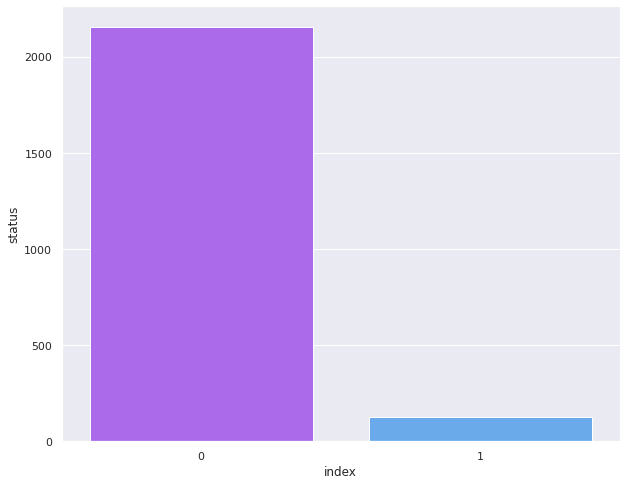

In [ ]:
# plotting the total number of patients having tested positve and negative for hypothyroidism.

patients =pd.DataFrame(data['status'].value_counts())

patients.reset_index(inplace=True)

sns.barplot(x=patients['index'], y=patients['status'], palette='cool_r')

A majority of the patients have received a negative diagnosis, only about 130 patients in the data have been diagnosed positive for hypothyroidism.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


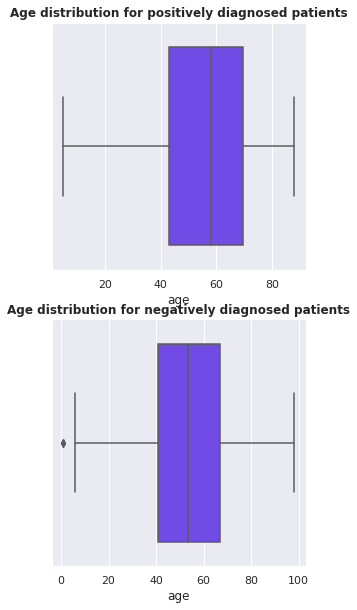

In [ ]:
# plotting the age of the patients distribution for negatively and positively diagnosed patients

pos =data[data['status']==1]
neg =data[data['status']==0]

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('Age distribution for positively diagnosed patients')
sns.boxplot(pos['age'], color='#6331FF')
plt.subplot(2,2,3)
plt.title('Age distribution for negatively diagnosed patients')
sns.boxplot(neg['age'], color='#6331FF')

The mean age for the positively diagnosed patient is larger than that of the negatively diagnosed patients, however the difference isn't very large.

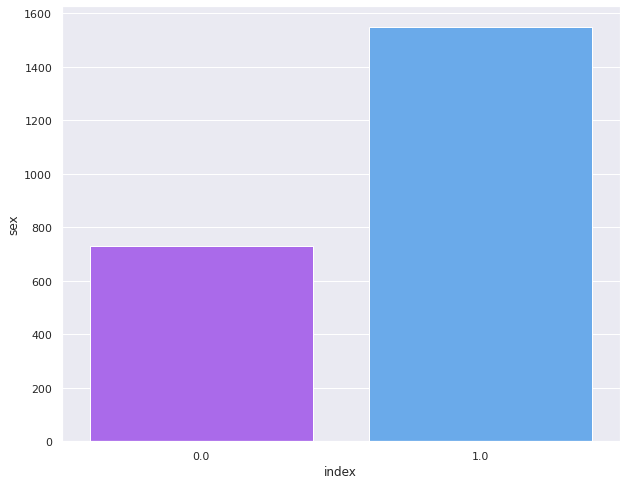

In [ ]:
# plotting the sexes count for the patients

sex =pd.DataFrame(data['sex'].value_counts())

sex.reset_index(inplace=True)

sns.barplot(x=sex['index'], y=sex['sex'], palette='cool_r')


A majority of the patients are female.

### Bivariate analysis

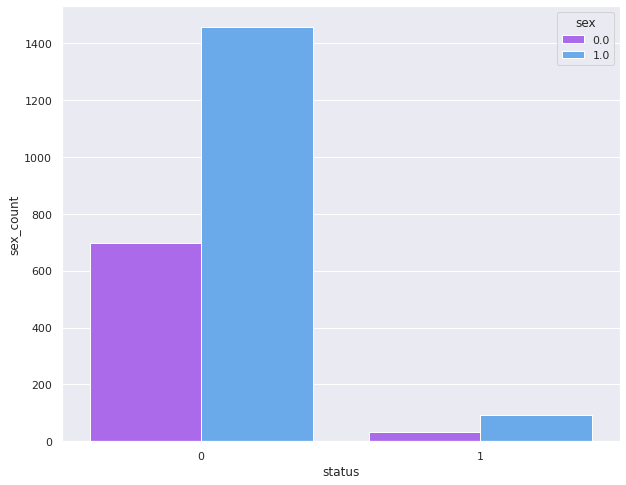

In [ ]:
# plotting a grouped bar graph for plotting the total number of patients tested positive and negative for hypothyroidism by gender.

by_sex = pd.DataFrame(data.groupby(by=['status'])['sex'].value_counts())
by_sex.columns = by_sex.columns.str.replace('sex','sex_count')
by_sex.reset_index(['sex'], inplace=True)

sns.barplot(x=by_sex.index, y=by_sex['sex_count'], hue=by_sex['sex'] ,palette='cool_r')


There is a larger difference in the number of male and female patients for those who got a negative diagnosis.

In [ ]:
# defining a function for plotting grouped bar graphs of the categorical variables in our dataset against the status variable

def plot_grouped(col):
  df = pd.DataFrame(data.groupby(by=['status'])[col].value_counts())
  df.columns = df.columns.str.replace(col,'count')
  df.reset_index([col], inplace=True)

  plt.title(f"\nStatus diagnosis by:{col} variable")
  sns.barplot(x=df.index, y=df['count'], hue=df[col] ,palette='cool_r')


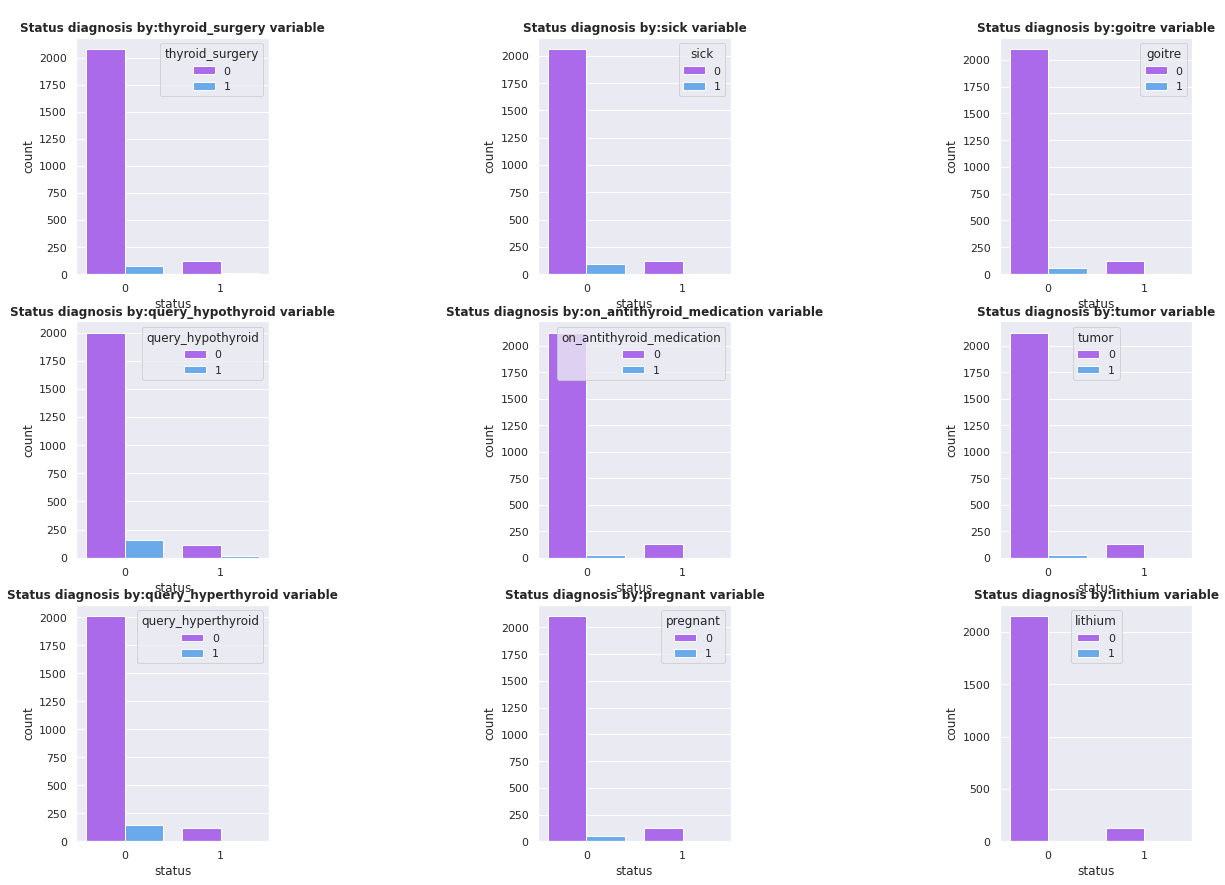

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(4,5,1)
plot_grouped('thyroid_surgery')
plt.subplot(4,5,3)
plot_grouped('sick')
plt.subplot(4,5,5)
plot_grouped('goitre')
plt.subplot(4,5,6)
plot_grouped('query_hypothyroid')
plt.subplot(4,5,8)
plot_grouped('on_antithyroid_medication')
plt.subplot(4,5,10)
plot_grouped('tumor')
plt.subplot(4,5,11)
plot_grouped('query_hyperthyroid')
plt.subplot(4,5,13)
plot_grouped('pregnant')
plt.subplot(4,5,15)
plot_grouped('lithium')

From the plot above I am able to infer the following:
- For all the above plotted variables, it appears that there is barely any patient diagnosed positive for hypothyroidism that exhibits the positive value(a yes value). 
- The plots don't give much information pertaining to positively diagnosed patients.

### Multivariate analysis

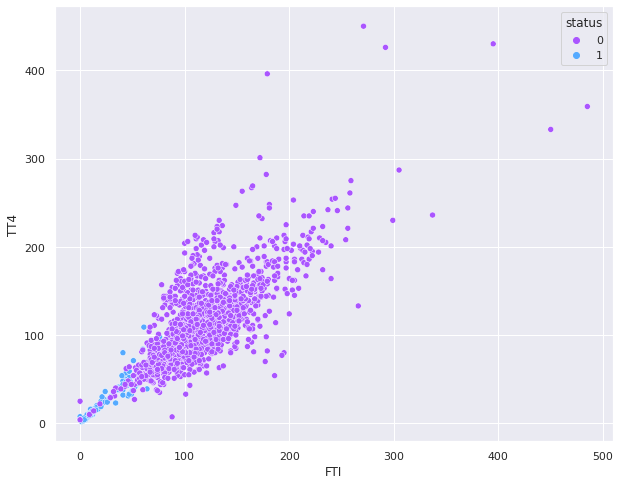

In [ ]:
# plotting a graph of the test results for TT4 test against those for FTI.

sns.scatterplot(x=data['FTI'], y=data['TT4'], hue=data['status'], palette='cool_r')

- There appears to be a direct linear relationship between the two test results.
- For both tests, patients with hypothyroidism exhibit lower value results.

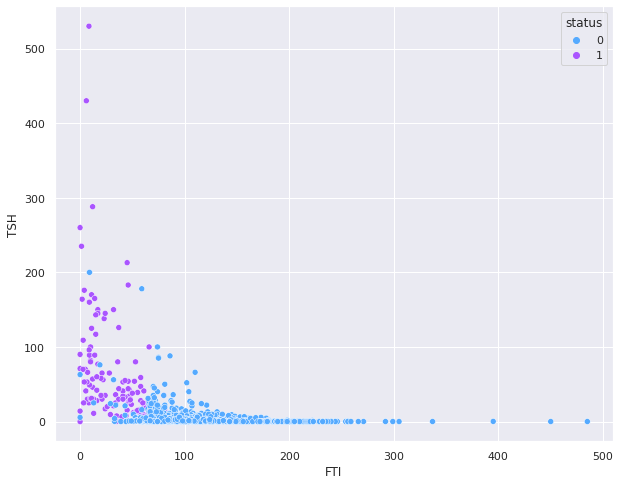

In [ ]:
# plotting a scatter plot for the FTI test results against the TSH test results.

sns.scatterplot(x=data['FTI'], y=data['TSH'], hue=data['status'], palette='cool')

- A polynomial relationship is exhibited between the two variables. 
- For the TSH tests lower values indicate lower chances of being diagnosed positive while for the FTI tests, lower values indicate higher chances of being diagnosed positive for hypothyroidism.


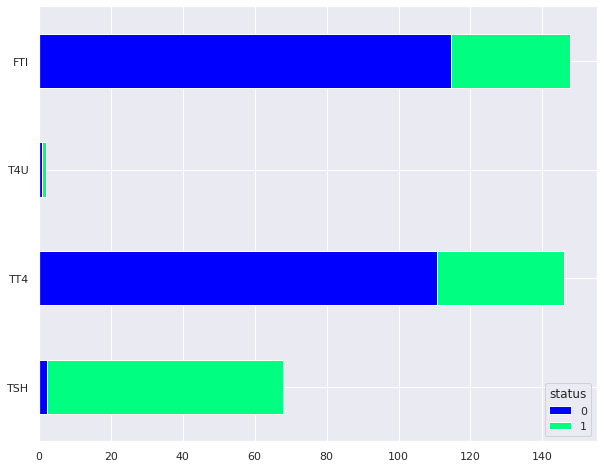

In [ ]:
# plotting the mean test results for the negatively and positively diagnosed patients

# creating a dataframe with only the status and the test result columns
Tests = data[['status', 'TSH', 'TT4', 'T4U', 'FTI']]

# groupng by status andcomputing the means
Tests = pd.DataFrame(Tests.groupby(by=['status']).mean())

# transposing my dataframe
trans =Tests.transpose(copy=True)

# plotting my graph
trans.plot(kind='barh', stacked=True, colormap='winter')



Patients that were positively diagnosed with hypothyroidism exhibited the following:
- significantly higher levels of TSH
- significantly lower result values for the FTI and TT4 tests.
- higher result values for the T4U tests

## Implementing the solution

i will first use a Random forest classifier to classify my data. 

#### Random Forest Classifier

In [ ]:
# set the variables for the x and the y axes
y= data['status'].values

feat = data.columns.tolist()
feat.remove('status') # the measured columns will not be of use as
# the column likely has only yeses being no value in the test results columns is missing

X= data[feat].values

# dividing our dataset to train and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.3, random_state=88)

# # instatiating my Random forest classifier
RFC = ensemble.RandomForestClassifier(max_depth=5)

# # fitting the model to our data
mod =RFC.fit(X_train, y_train)

# # predicting the values for y using the X_test set

predictions =RFC.predict(X_test)

print('The random forest classifier was able to acheive an accuracy of',(metrics.accuracy_score(y_test, predictions)*100),"%")
# #params ={} 

The random forest classifier was able to acheive an accuracy of 97.953216374269 %


In [ ]:
# using grid search to optimize my model.

# creating a dictionary with my parameters
params = {'n_estimators':[100,150,200,250,300], 'criterion':['gini','entropy'], 'max_features':['auto','log2']}

# instatiating my grisearchcv
grid = model_selection.GridSearchCV(estimator=RFC, param_grid=params, n_jobs=-1, cv=10)

# fitting the model to my training data
grid.fit(X_train, y_train)

# displaying the best parameters
grid.best_params_

{'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 100}

In [ ]:
# instatiating my Random forest classifier and inputing the best pparameters
be = grid.best_estimator_

# fitting the classifier to my training data
model =be.fit(X_train, y_train)

# geneating predicted values
pred =model.predict(X_test)

# computing the accuracy score
print('The modified random forest classifier was able to acheive an accuracy of',(metrics.accuracy_score(y_test, pred)*100),"%")

The modified random forest classifier was able to acheive an accuracy of 98.53801169590643 %


A slightly better accuracy was achieved by the optimized model.

Text(0.5, 1.0, 'Feature Importances')

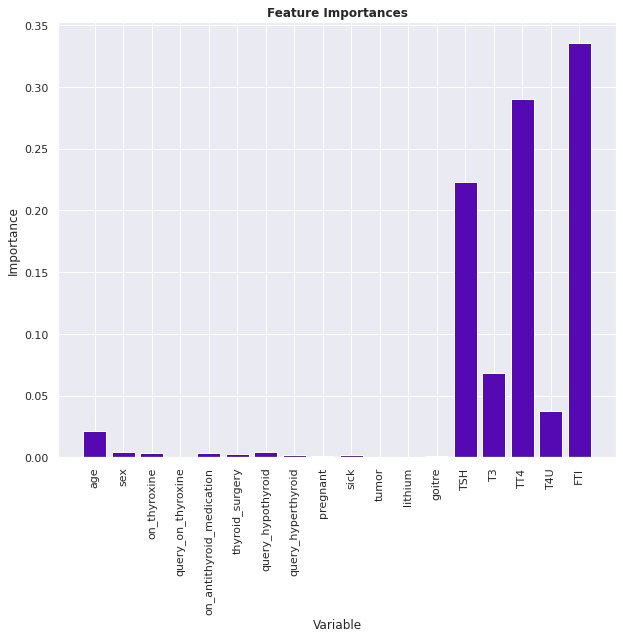

In [ ]:
#plotting the feature importances

feat_importances = list(model.feature_importances_)

x_values = list(range(len(feat_importances)))

# plotting my bar chart
plt.bar(x_values, feat_importances, orientation = 'vertical', color='#5509B3')
plt.xticks(x_values, feat, rotation='vertical')

# Setting the title and axes label for the viz
plt.ylabel('Importance')
plt.xlabel('Variable') 
plt.title('Feature Importances')

The FTI tests results appear to be the most important feature. The variables containing the different tests results are evidently the most important features considered in the prediction.

#### Gradient Boosting Classifier

In [ ]:
# instatiating GB classifier
GBC = ensemble.GradientBoostingClassifier(max_depth=1)

# fitting gradient boost to my training data
gr_boost = GBC.fit(X_train, y_train)

# generating the predicted values
predited =gr_boost.predict(X_test)

# calculating the accuracy score
print("Our GBC model achieves an accuracy of",(metrics.accuracy_score(y_test, predited)*100),"%.")

Our GBC model achieves an accuracy of 98.39181286549707 %.


The accuracy is pretty good. The model slightly worse than the optimal Random Forest model.

In [ ]:
# tuning my hyperparameters to acquire better results

parameters = {'loss':['deviance','exponential'], 'n_estimators':[100,150,200,250,300,350],
              'learning_rate':[0.1,0.001,0.01,0.0001], 'subsample':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], 'max_features':[0.2,0.3,0.4,0.1]}
grid_boost= model_selection.GridSearchCV(estimator=GBC, param_grid=parameters,n_jobs=-1, cv=10)

grid_boost.fit(X_train, y_train)

grid_boost.best_params_

{'learning_rate': 0.1,
 'loss': 'deviance',
 'max_features': 0.4,
 'n_estimators': 300,
 'subsample': 0.8}

In [46]:
# fitting the model with the best parameters to our training data
mode =grid.best_estimator_

mode.fit(X_train, y_train)

p = mode.predict(X_test)

print("Our GBC modified model is able to achieve an accuracy of",(metrics.accuracy_score(y_test, p)*100),"%.")

Our GBC modified model is able to achieve an accuracy of 98.39181286549707 %.


The accuracy for our gradient boosting model is 98.39%. It is similar to the accuracy value we found before hypertuning the parameters.

#### Support vector machine

Using PCA to determine the features responsible most suitable for use in my model, i.e the features causing the largest variations in my dataset.

In [47]:
# Scaling my data

# instatiating standard scaler 
sc = preprocessing.StandardScaler()

# fitting to my X_train

train_standardized = sc.fit_transform(X_train)
test_standardized = sc.transform(X_test)

In [48]:
# Performing PCA

# instatiating PCA
pca = decomposition.PCA(n_components=12) # setting the n_components to six, reflective of the six features with the highest feature importances 

# fitting the model
X_tr_pca = pca.fit_transform(train_standardized)
X_te_pca = pca.transform(test_standardized)

# outputting the explained variance ratios

explained_var = pca.explained_variance_ratio_
explained_var

array([0.14899183, 0.09986993, 0.07245538, 0.06173421, 0.06083253,
       0.05790245, 0.05618886, 0.05554957, 0.05494807, 0.05163121,
       0.04910041, 0.04683667])

In [49]:
explained_var.sum()

0.8160410955130676

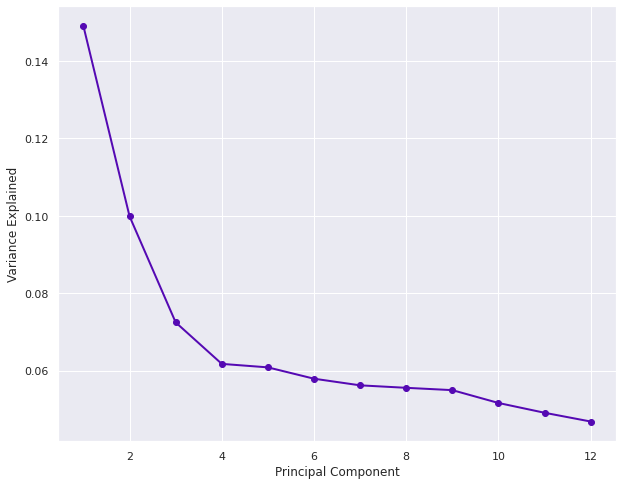

In [50]:
# plotting the scree plot

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, explained_var, 'o-', linewidth=2, color='#5509B3')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

Upon setting my n_components to six: 
- The first variable explains 14% of the variation in the dataset while the sixth component explains 5% of the variation in the dataset.
- Cumulatively the six components explain around 50% percent of the variation in the dataset. I need to increase the n_components to increase my cumulative explained variance for a more accurate model to be built.

Upon increasing the n_components to twelve:
- The first component explains 14% of the variation in the dataset while the twelfth component expains 4.6% of the variation in the dataset.
- Cumulatively the 12 components explain around 81% of the variation in the dataset. I can now confidently buid my model.


In [51]:
# instatiating my support vector classifier
svc = svm.SVC()  

# fitting my model
mod_svm = svc.fit(X_tr_pca, y_train)

# generating the predicted values
s_pred = mod_svm.predict(X_te_pca)

# computing the accuracy score
print("My SVM model acheives an accuracy of",(metrics.accuracy_score(y_test, s_pred)*100),"%")

My SVM model acheives an accuracy of 97.36842105263158 %


Using grid search to tune hyperparameters for optimization of my svm model

In [52]:
paramets = {'kernel':['linear', 'rbf', 'polynomial'], 'gamma':[0.0001, 0.001, 0.01, 0.1, 1, 10], 'C':[0.0001, 0.001, 0.01, 0.1, 10, 100]}

grid_svm = model_selection.GridSearchCV(estimator=svc, param_grid= paramets, n_jobs=-1, cv=10)

grid_svm.fit(X_tr_pca, y_train)
grid_svm.best_params_

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

In [55]:
# fitting the best estimator model to my training data and computing the accuracy of the model

best_est =grid_svm.best_estimator_

new_mod =best_est.fit(X_tr_pca, y_train)

snew_pred = new_mod.predict(X_te_pca)

print("My new SVM model achieves an accuracy of",(metrics.accuracy_score(y_test, s_pred)*100),"%")


My new SVM model achieves an accuracy of 97.36842105263158 %


The model, even after hypertuning of the parameters, achieves an accuracy of 97.36%.

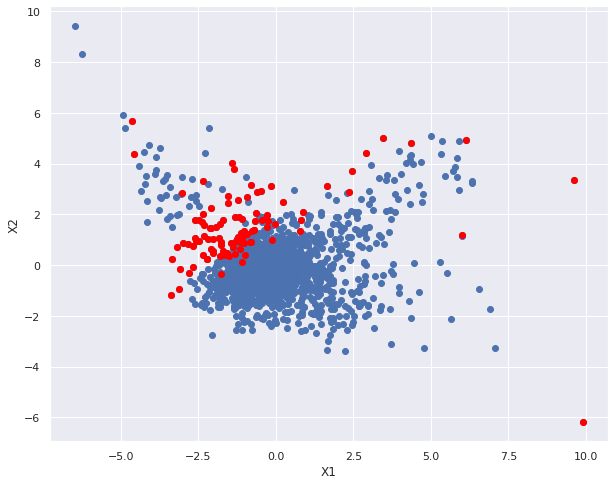

In [56]:
# plotting my svm surface
# Get support vectors themselves
support_vectors = new_mod.support_vectors_

# Visualize support vectors
plt.scatter(X_tr_pca[:,0], X_tr_pca[:,1])
plt.scatter(support_vectors[:,0], support_vectors[:,1], color='red')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

## Challenging the solution

By using a voting classifier, I can achieve a higher accuracy than that achieved by gradient boost and random forest classifier, as it takes into account the predicted results from multiple already efficient classifiers. I will perform logistic regression on my data. I can then use the three classifiers to achieve optimal accuracy. I need three classifiers, as the voting classifier uses majority voting, therefore, having only two votes is not optimal.

In [57]:
# importing Logistic regression from  sklearn.linear_model
from sklearn.linear_model import LogisticRegression

Log = LogisticRegression(max_iter=500)

log_model =Log.fit(X_train, y_train)

y_pred = log_model.predict(X_test)

print("My logistic regression model achieves an accuracy of",(metrics.accuracy_score(y_test, y_pred)*100),"%")

My logistic regression model achieves an accuracy of 97.6608187134503 %


Our logistic regression model has a lower accuracy than both Gradient Boosting and Random forest classifiers.

In [59]:
# instatiating the voting classifier

classifiers = [('Logistic regression', Log), ('Gradient Bossting Classifier', GBC), ('Random Forest Classifier', RFC)]
VC =ensemble.VotingClassifier(classifiers)

voted =VC.fit(X_train, y_train)

predicted =voted.predict(X_test)

print("Upon using a voting classifier, the accuracy achieved results to",(metrics.accuracy_score(y_test, predicted)*100),"%")





Upon using a voting classifier, the accuracy achieved results to 98.53801169590643 %


The accuracy achieved by the Voting classifier is 98.53% which is slightly better than the accuracy achieved by the Gradient boosting classifier, Logistic Regression and the Support vector classifier.
The accuracy is similar to that achieved by the optimal Random Forest Classifier model.